In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import os
import numpy as np
import astropy.units as u
from astropy.coordinates import SkyCoord, Angle
from regions import CircleSkyRegion
from gammapy.spectrum import (
    SpectrumDatasetOnOff,
    SpectrumDataset,
    SpectrumDatasetMaker,
)
from gammapy.modeling import Fit, Parameter
from gammapy.modeling.models import (
    PowerLawSpectralModel,
    SpectralModel,
    SkyModel,
    ExpCutoffPowerLawSpectralModel,
)
from gammapy.irf import load_cta_irfs
from gammapy.data import Observation
from gammapy.maps import MapAxis

In [3]:
livetime = 48 * u.h
pointing = SkyCoord(0, 0, unit="deg", frame="galactic")
offset = 0.5 * u.deg
# Reconstructed and true energy axis
energy_axis = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 10), unit="TeV", name="energy", interp="log"
)
energy_axis_true = MapAxis.from_edges(
    np.logspace(-1.5, 2.0, 31), unit="TeV", name="energy", interp="log"
)

on_region_radius = Angle("0.11 deg")
on_region = CircleSkyRegion(center=pointing, radius=on_region_radius)

In [4]:
# Define spectral model - a simple Power Law in this case
model_simu = ExpCutoffPowerLawSpectralModel(
    index=2.22,
    amplitude=1.289e-12 * u.Unit("cm-2 s-1 TeV-1"),
    reference=1 * u.TeV,
    lambda_=0.5 * u.Unit("TeV-1"),
    alpha = 1,
)
print(model_simu)
# we set the sky model used in the dataset
model = SkyModel(spectral_model=model_simu)

ExpCutoffPowerLawSpectralModel

   name     value   error      unit      min max frozen
--------- --------- ----- -------------- --- --- ------
    index 2.220e+00   nan                nan nan  False
amplitude 1.289e-12   nan cm-2 s-1 TeV-1 nan nan  False
reference 1.000e+00   nan            TeV nan nan   True
  lambda_ 5.000e-01   nan          TeV-1 nan nan  False
    alpha 1.000e+00   nan                nan nan   True


In [5]:
os.environ['CALDB'] = '/home/rishank/anaconda2/envs/cta/share/caldb/'
!echo $CALDB
!ls $CALDB

/home/rishank/anaconda2/envs/cta/share/caldb/
data


In [6]:
# Load the IRFs
# In this simulation, we use the CTA-1DC irfs shipped with gammapy.
irfs = load_cta_irfs(
    "$CALDB/data/cta/prod3b-v2/bcf/South_z20_50h/irf_file.fits"
)

In [7]:
obs = Observation.create(pointing=pointing, livetime=livetime, irfs=irfs)
print(obs)

Info for OBS_ID = 1
- Pointing pos: RA 266.40 deg / Dec -28.94 deg
- Livetime duration: 172800.0 s



In [8]:
# Make the SpectrumDataset
dataset_empty = SpectrumDataset.create(
    e_reco=energy_axis.edges, e_true=energy_axis_true.edges, region=on_region
)
maker = SpectrumDatasetMaker(selection=["aeff", "edisp", "background"])
dataset = maker.run(dataset_empty, obs)

In [9]:
# Set the model on the dataset, and fake
dataset.model = model
dataset.fake(random_state=42)
print(dataset)

SpectrumDataset

    Name                            : 1 

    Total counts                    : 20280 
    Total predicted counts          : nan
    Total background counts         : 20309.41

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 1.73e+05 s

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : cash
    Fit statistic value (-2 log(L)) : nan

    Number of parameters            : 0
    Number of free parameters       : 0




In [10]:
dataset_onoff = SpectrumDatasetOnOff(
    aeff=dataset.aeff,
    edisp=dataset.edisp,
    models=model,
    livetime=livetime,
    acceptance=1,
    acceptance_off=5,
)
dataset_onoff.fake(background_model=dataset.background)
print(dataset_onoff)

SpectrumDatasetOnOff

    Name                            :  

    Total counts                    : 33362 
    Total predicted counts          : 33157.66
    Total off counts                : 101141.00

    Total background counts         : 20228.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.17

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0



In [11]:

%%time

n_obs = 1000
datasets = []

for idx in range(n_obs):
    dataset_onoff.fake(random_state=idx, background_model=dataset.background)
    dataset_onoff.name = f"obs_{idx}"
    datasets.append(dataset_onoff.copy())

CPU times: user 3.08 s, sys: 17.5 ms, total: 3.09 s
Wall time: 3.09 s


In [12]:
print(*datasets, sep = "\n") 

SpectrumDatasetOnOff

    Name                            : obs_0 

    Total counts                    : 33357 
    Total predicted counts          : 33342.46
    Total off counts                : 102065.00

    Total background counts         : 20413.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.64

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_1 

    Total counts                    : 32889 
    Total predicted counts          : 33263.86
    Total off counts                : 101672.00

    Total background counts         : 20

SpectrumDatasetOnOff

    Name                            : obs_34 

    Total counts                    : 33495 
    Total predicted counts          : 33203.26
    Total off counts                : 101369.00

    Total background counts         : 20273.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_35 

    Total counts                    : 33106 
    Total predicted counts          : 33221.86
    Total off counts                : 101462.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_68 

    Total counts                    : 33294 
    Total predicted counts          : 33145.66
    Total off counts                : 101081.00

    Total background counts         : 20216.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.03

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_69 

    Total counts                    : 33008 
    Total predicted counts          : 33227.66
    Total off counts                : 101491.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_89 

    Total counts                    : 32842 
    Total predicted counts          : 33074.06
    Total off counts                : 100723.00

    Total background counts         : 20144.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.88

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_90 

    Total counts                    : 33063 
    Total predicted counts          : 33236.86
    Total off counts                : 101537.00

    Total background counts         : 

SpectrumDatasetOnOff

    Name                            : obs_125 

    Total counts                    : 33456 
    Total predicted counts          : 33135.86
    Total off counts                : 101032.00

    Total background counts         : 20206.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.55

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_126 

    Total counts                    : 33185 
    Total predicted counts          : 33159.66
    Total off counts                : 101151.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_155 

    Total counts                    : 32917 
    Total predicted counts          : 33112.46
    Total off counts                : 100915.00

    Total background counts         : 20183.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_156 

    Total counts                    : 32989 
    Total predicted counts          : 33274.46
    Total off counts                : 101725.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_186 

    Total counts                    : 33428 
    Total predicted counts          : 33242.86
    Total off counts                : 101567.00

    Total background counts         : 20313.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.83

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_187 

    Total counts                    : 33201 
    Total predicted counts          : 33157.06
    Total off counts                : 101138.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_219 

    Total counts                    : 33077 
    Total predicted counts          : 33250.86
    Total off counts                : 101607.00

    Total background counts         : 20321.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 11.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_220 

    Total counts                    : 32995 
    Total predicted counts          : 33242.66
    Total off counts                : 101566.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_255 

    Total counts                    : 33218 
    Total predicted counts          : 33140.46
    Total off counts                : 101055.00

    Total background counts         : 20211.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_256 

    Total counts                    : 33346 
    Total predicted counts          : 33238.26
    Total off counts                : 101544.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_292 

    Total counts                    : 33168 
    Total predicted counts          : 33223.06
    Total off counts                : 101468.00

    Total background counts         : 20293.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.62

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_293 

    Total counts                    : 33404 
    Total predicted counts          : 33328.46
    Total off counts                : 101995.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_328 

    Total counts                    : 33146 
    Total predicted counts          : 33218.86
    Total off counts                : 101447.00

    Total background counts         : 20289.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.28

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_329 

    Total counts                    : 33116 
    Total predicted counts          : 33247.46
    Total off counts                : 101590.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_366 

    Total counts                    : 33254 
    Total predicted counts          : 33241.26
    Total off counts                : 101559.00

    Total background counts         : 20311.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.70

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_367 

    Total counts                    : 33188 
    Total predicted counts          : 33243.26
    Total off counts                : 101569.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_400 

    Total counts                    : 33416 
    Total predicted counts          : 33227.86
    Total off counts                : 101492.00

    Total background counts         : 20298.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.38

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_401 

    Total counts                    : 33140 
    Total predicted counts          : 33239.46
    Total off counts                : 101550.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_435 

    Total counts                    : 33381 
    Total predicted counts          : 33132.66
    Total off counts                : 101016.00

    Total background counts         : 20203.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.29

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_436 

    Total counts                    : 33005 
    Total predicted counts          : 33238.86
    Total off counts                : 101547.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_470 

    Total counts                    : 33133 
    Total predicted counts          : 33132.86
    Total off counts                : 101017.00

    Total background counts         : 20203.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 2.87

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_471 

    Total counts                    : 33073 
    Total predicted counts          : 33237.46
    Total off counts                : 101540.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_506 

    Total counts                    : 33245 
    Total predicted counts          : 33228.86
    Total off counts                : 101497.00

    Total background counts         : 20299.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 4.57

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_507 

    Total counts                    : 33116 
    Total predicted counts          : 33117.66
    Total off counts                : 100941.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_542 

    Total counts                    : 33226 
    Total predicted counts          : 33277.26
    Total off counts                : 101739.00

    Total background counts         : 20347.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.67

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_543 

    Total counts                    : 33065 
    Total predicted counts          : 33229.46
    Total off counts                : 101500.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_579 

    Total counts                    : 33077 
    Total predicted counts          : 33180.66
    Total off counts                : 101256.00

    Total background counts         : 20251.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.39

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_580 

    Total counts                    : 33352 
    Total predicted counts          : 33337.46
    Total off counts                : 102040.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_614 

    Total counts                    : 33205 
    Total predicted counts          : 33135.46
    Total off counts                : 101030.00

    Total background counts         : 20206.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 5.97

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_615 

    Total counts                    : 33333 
    Total predicted counts          : 33188.66
    Total off counts                : 101296.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_651 

    Total counts                    : 33260 
    Total predicted counts          : 33174.66
    Total off counts                : 101226.00

    Total background counts         : 20245.20

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.07

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_652 

    Total counts                    : 32990 
    Total predicted counts          : 33246.06
    Total off counts                : 101583.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_687 

    Total counts                    : 33232 
    Total predicted counts          : 33176.46
    Total off counts                : 101235.00

    Total background counts         : 20247.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 3.48

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_688 

    Total counts                    : 33239 
    Total predicted counts          : 33243.06
    Total off counts                : 101568.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_722 

    Total counts                    : 33045 
    Total predicted counts          : 33202.86
    Total off counts                : 101367.00

    Total background counts         : 20273.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 9.92

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_723 

    Total counts                    : 33300 
    Total predicted counts          : 33271.66
    Total off counts                : 101711.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_757 

    Total counts                    : 33190 
    Total predicted counts          : 33110.46
    Total off counts                : 100905.00

    Total background counts         : 20181.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.71

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_758 

    Total counts                    : 32963 
    Total predicted counts          : 33163.26
    Total off counts                : 101169.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_793 

    Total counts                    : 33130 
    Total predicted counts          : 33306.86
    Total off counts                : 101887.00

    Total background counts         : 20377.40

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 6.93

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_794 

    Total counts                    : 33488 
    Total predicted counts          : 33267.86
    Total off counts                : 101692.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_830 

    Total counts                    : 33351 
    Total predicted counts          : 33186.06
    Total off counts                : 101283.00

    Total background counts         : 20256.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 13.95

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_831 

    Total counts                    : 33370 
    Total predicted counts          : 33226.66
    Total off counts                : 101486.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_864 

    Total counts                    : 33318 
    Total predicted counts          : 33250.26
    Total off counts                : 101604.00

    Total background counts         : 20320.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 20.32

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_865 

    Total counts                    : 32961 
    Total predicted counts          : 33236.46
    Total off counts                : 101535.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_899 

    Total counts                    : 33358 
    Total predicted counts          : 33292.46
    Total off counts                : 101815.00

    Total background counts         : 20363.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 14.37

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_900 

    Total counts                    : 33332 
    Total predicted counts          : 33189.86
    Total off counts                : 101302.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_928 

    Total counts                    : 33174 
    Total predicted counts          : 33210.26
    Total off counts                : 101404.00

    Total background counts         : 20280.80

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 7.18

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_929 

    Total counts                    : 33373 
    Total predicted counts          : 33269.46
    Total off counts                : 101700.00

    Total background counts         

SpectrumDatasetOnOff

    Name                            : obs_960 

    Total counts                    : 33547 
    Total predicted counts          : 33212.46
    Total off counts                : 101415.00

    Total background counts         : 20283.00

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 12.34

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_961 

    Total counts                    : 33357 
    Total predicted counts          : 33201.66
    Total off counts                : 101361.00

    Total background counts        

SpectrumDatasetOnOff

    Name                            : obs_994 

    Total counts                    : 33081 
    Total predicted counts          : 33184.06
    Total off counts                : 101273.00

    Total background counts         : 20254.60

    Effective area min              : 3.44e+04 m2
    Effective area max              : 5.41e+06 m2

    Livetime                        : 4.80e+01 h

    Number of total bins            : 9 
    Number of fit bins              : 9 

    Fit statistic type              : wstat
    Fit statistic value (-2 log(L)) : 8.44

    Number of parameters            : 5
    Number of free parameters       : 3

    Model type                      : SkyModels
    Acceptance mean:                : 1.0

SpectrumDatasetOnOff

    Name                            : obs_995 

    Total counts                    : 33003 
    Total predicted counts          : 33191.66
    Total off counts                : 101311.00

    Total background counts         

Text(0, 0.5, 'No. of observations')

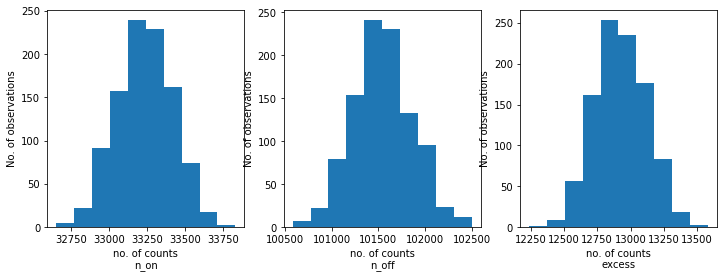

In [13]:

n_on = [dataset.counts.data.sum() for dataset in datasets]
n_off = [dataset.counts_off.data.sum() for dataset in datasets]
excess = [dataset.excess.data.sum() for dataset in datasets]

fix, axes = plt.subplots(1, 3, figsize=(12, 4))
axes[0].hist(n_on)
axes[0].set_xlabel("no. of counts\nn_on")
axes[0].set_ylabel("No. of observations")
axes[1].hist(n_off)
axes[1].set_xlabel("no. of counts\nn_off")
axes[1].set_ylabel("No. of observations")
axes[2].hist(excess)
axes[2].set_xlabel("no. of counts\nexcess");
axes[2].set_ylabel("No. of observations")

In [14]:

%%time
results = []
for dataset in datasets:
    dataset.models = model.copy()
    fit = Fit([dataset])
    result = fit.optimize()
    results.append(
        {
            "index": result.parameters["index"].value,
            "amplitude": result.parameters["amplitude"].value,
            "lambda_": result.parameters["lambda_"].value,
        }
    )

CPU times: user 4min 10s, sys: 627 ms, total: 4min 10s
Wall time: 4min 14s


In [15]:
results

[{'index': 2.232538916476606,
  'amplitude': 1.2373518606812286e-12,
  'lambda_': 0.44514007771400643},
 {'index': 2.1921386356870185,
  'amplitude': 1.3405471272444897e-12,
  'lambda_': 0.5539388397471491},
 {'index': 2.2390306532290274,
  'amplitude': 1.2114311723919235e-12,
  'lambda_': 0.481853635003571},
 {'index': 2.2381540033754255,
  'amplitude': 1.2512809290515709e-12,
  'lambda_': 0.5030039142543251},
 {'index': 2.241836083562033,
  'amplitude': 1.2686520335181529e-12,
  'lambda_': 0.5059561427729724},
 {'index': 2.1818599630503877,
  'amplitude': 1.3849873943605872e-12,
  'lambda_': 0.5523709213406991},
 {'index': 2.2361683329909523,
  'amplitude': 1.2748053201934255e-12,
  'lambda_': 0.4974112233182603},
 {'index': 2.2015748888965336,
  'amplitude': 1.3344334689422759e-12,
  'lambda_': 0.5278376715864108},
 {'index': 2.2232129757923187,
  'amplitude': 1.2387241715088374e-12,
  'lambda_': 0.45697540823556376},
 {'index': 2.257772560517059,
  'amplitude': 1.153001391526499e-1

index: 2.219104835766239 += 0.02261740743457858


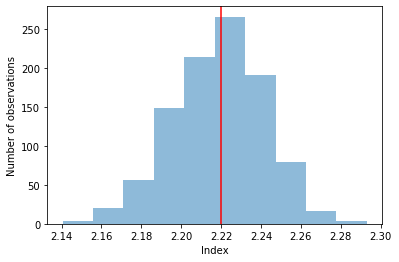

In [16]:
index = np.array([_["index"] for _ in results])
plt.hist(index, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["index"].value, color="red")
plt.xlabel("Index")
plt.ylabel("Number of observations")
print(f"index: {index.mean()} += {index.std()}")

amplitude: 1.2930148098030494e-12 += 6.407439067467697e-14


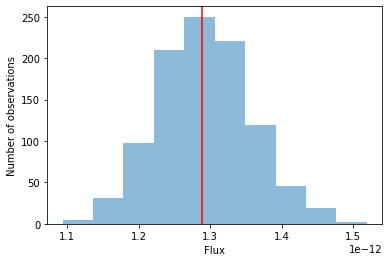

In [17]:
amplitude = np.array([_["amplitude"] for _ in results])
plt.hist(amplitude, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["amplitude"].value, color="red")
plt.xlabel("Flux")
plt.ylabel("Number of observations")
print(f"amplitude: {amplitude.mean()} += {amplitude.std()}")

lambda_: 0.5027399829048604 += 0.03695976942784828


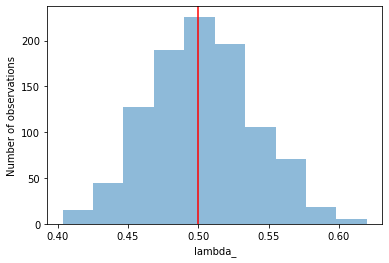

In [18]:
lambda_ = np.array([_["lambda_"] for _ in results])
plt.hist(lambda_, bins=10, alpha=0.5)
plt.axvline(x=model_simu.parameters["lambda_"].value, color="red")
plt.xlabel("lambda_")
plt.ylabel("Number of observations")
print(f"lambda_: {lambda_.mean()} += {lambda_.std()}")